## Migration from chaotic tides

This notebook shows how to include the effects of dynamical tides in high-eccentricity migration. In particular, for near-unity eccentricities, fundamental (f) modes can be excited within orbiting bodies, which can lead to chaotic dissipation of orbital energy and rapid inward migration.

In this example, we consider the case of a migrating warm Jupiter, as in [Liveoak et al. (2025)](https://iopscience.iop.org/article/10.3847/1538-4357/adefe7/meta) and [Vick et al. (2019).](https://academic.oup.com/mnras/article/484/4/5645/5306464)

In [1]:
# Example of chaotic migration using the dynamical tides force
import rebound
import reboundx
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

We need to set both the planet mass and radius:

In [2]:
# initial conditions
a0 = 1.5
e0 = 0.987
R_planet = 1.6 * 4.67e-4 # 1.6 Jupiter radii
m_planet = 1e-3 # approximately 1 Jupiter mass

# create simulation
sim = rebound.Simulation()
sim.units = ['AU', 'yr', 'Msun']
sim.add(m=1)
sim.add(m=m_planet, r=R_planet, a=a0, e=e0)
sim.move_to_com()
ps = sim.particles

Here, we add the dynamical tides effect. For detailed studies of tidal dynamics, we recommend including additional relevant short-range forces (such as `gr` and `tides_constant_time_lag`), but we omit them here for clarity.

In [3]:
# load reboundx and the dynamical tides operator
rebx = reboundx.Extras(sim)
td = rebx.load_force('tides_dynamical')
rebx.add_force(td)

Now we integrate. We print a few diagnostics every 100 outputs. The last two columns are the mode energy E, and FILL IN

In [4]:
%%time
N = 1000
t = np.linspace(0, 2.5e3, N) # time
a = np.zeros(N) # semi-major axis
e = np.zeros(N) # eccentricity
E = np.zeros(N) # mode energy

# record initial orbital energy
EB0 = -sim.G * ps[1].m * ps[0].m / (2 * ps[1].a)

for i, time in enumerate(t):
    a[i] = ps[1].a
    e[i] = ps[1].e
    try:
        E[i] = abs(EB0) * (ps[1].params['td_c_imag']**2 + ps[1].params['td_c_real']**2)
    except:
        E[i] = 0 # td_c values not set until after first timestep
        
    if i % 100 == 0 and i != 0:
        print(time, ps[1].a, ps[1].e, E[i])
    
    sim.integrate(time)

250.25025025025025 1.036080565261779 0.981182373246606 0.0004974175022768904
500.5005005005005 0.7993251742779253 0.9756128400732693 0.0004222675782672578
750.7507507507507 0.6570290365642172 0.9703359977473456 6.784774893322658e-05
1001.001001001001 0.4226872676951968 0.9539136759748658 2.2420939361029427e-05
1251.2512512512512 0.42289008382309884 0.9539357465304994 1.5651688082016036e-07
1501.5015015015015 0.42288927649518354 0.9539356587185627 2.2489258654395876e-05
1751.7517517517517 0.4226843516327913 0.9539133584932327 2.045087445525241e-07
2002.002002002002 0.4228875333150158 0.9539354691141332 2.322509661352961e-07
2252.252252252252 0.4226821824023189 0.9539131223188957 2.2646405660029303e-05
CPU times: user 7.68 s, sys: 10.8 ms, total: 7.69 s
Wall time: 7.69 s


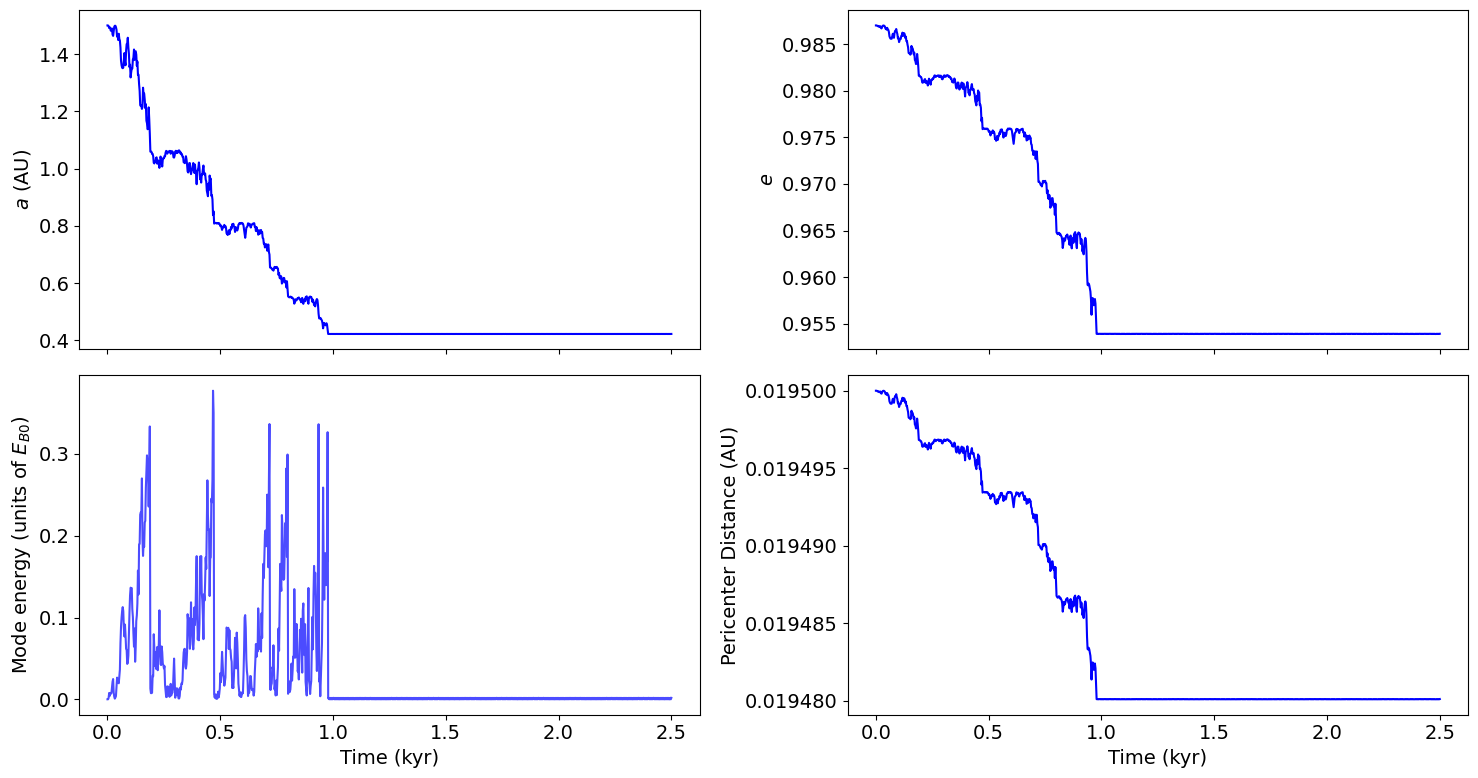

In [5]:
fig, axes = plt.subplots(2, 2, sharex=True)
fig.set_figheight(8)
fig.set_figwidth(15)

axes[0, 0].plot(t / 1e3, a, c='blue')
axes[0, 0].set_ylabel(r'$a$ (AU)')

axes[0, 1].plot(t / 1e3, e, c='blue')
axes[0, 1].set_ylabel(r'$e$')

axes[1, 0].plot(t / 1e3, -E / EB0, alpha=0.7, c='blue')
axes[1, 0].set_ylabel(r'Mode energy (units of $E_{B0}$)')
axes[1, 0].set_xlabel(r'Time (kyr)')

axes[1, 1].plot(t / 1e3, a * (1-e), c='blue')
axes[1, 1].set_ylabel(r'Pericenter Distance (AU)')
axes[1, 1].set_xlabel(r'Time (kyr)')

plt.tight_layout()

There are also several optional parameters available. 

- You can try to speed up integrations by adopting a minimum change `td_dP_crit` in mode phase at which dynamical tides turn on
- You can change the threshold energy `td_E_max` at which modes are assumed to undergo non-linear dissipation
- You can change the residual energy after non-linear dissipation `td_E_resid`

Finally, the code will raise a warning if the planet becomes tidally disrupted. You can set also set `td_disruption_flag` to instead raise an exception that can be custom-handled, e.g.


In [6]:
td.params['td_disruption_flag'] = True
try:
    sim.integrate(2300)
except:
    sim.remove(1) # or whatever else you'd like to do